# Dependencies

In [1]:
!pip install huggingface_hub
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00


In [2]:
!mkdir data_original
!mkdir data_cleaned_original_split
!mkdir data_cleaned_merged
!mkdir data_cleaned_balanced_split

In [3]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [4]:
!pip install transformers
!pip install nltk

import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

# Loading and transforming dataset into the required form

In [5]:
from datasets import load_dataset

ds = load_dataset("opennyaiorg/InLegalNER")

train_dataset = load_dataset("opennyaiorg/InLegalNER", split="train")
dev_dataset = load_dataset("opennyaiorg/InLegalNER", split="dev")
test_dataset  = load_dataset("opennyaiorg/InLegalNER", split="test")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/3.14k [00:00<?, ?B/s]

(…)-00000-of-00001-de25c1ae1db42f79.parquet:   0%|          | 0.00/3.53M [00:00<?, ?B/s]

(…)-00000-of-00001-b148266485fd7aeb.parquet:   0%|          | 0.00/389k [00:00<?, ?B/s]

(…)-00000-of-00001-814a730def5e8488.parquet:   0%|          | 0.00/1.52M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10995 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/1074 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/4501 [00:00<?, ? examples/s]

In [6]:
dev_df = pd.DataFrame(dev_dataset)
train_df = pd.DataFrame(train_dataset)
test_df = pd.DataFrame(test_dataset)

In [7]:
dev_df["annotations"][0]

[{'result': [{'from_name': 'label',
    'id': '25TFDATV',
    'to_name': 'text',
    'type': 'labels',
    'value': {'end': 22,
     'labels': ['STATUTE'],
     'start': 10,
     'text': 'Constitution'}},
   {'from_name': 'label',
    'id': 'F706LMQM',
    'to_name': 'text',
    'type': 'labels',
    'value': {'end': 155,
     'labels': ['PRECEDENT'],
     'start': 108,
     'text': 'R.C. Cooper v. Union of India, (1970) 1 SCC 248'}},
   {'from_name': 'label',
    'id': '2EURBJSZ',
    'to_name': 'text',
    'type': 'labels',
    'value': {'end': 209,
     'labels': ['PRECEDENT'],
     'start': 160,
     'text': 'Maneka Gandhi v. Union of India, (1978) 1 SCC 248'}}]}]

In [8]:
dev_df["data"][0]

{'text': "True, our Constitution has no 'due process' clause or the VIII Amendment; but, in this branch of law, after R.C. Cooper v. Union of India, (1970) 1 SCC 248 and Maneka Gandhi v. Union of India, (1978) 1 SCC 248, the consequence is the same."}

In [9]:
tags = [
    "COURT",
    "PETITIONER",
    "RESPONDENT",
    "JUDGE",
    "LAWYER",
    "DATE",
    "ORG",
    "GPE",
    "STATUTE",
    "PROVISION",
    "PRECEDENT",
    "CASE_NUMBER",
    "WITNESS",
    "OTHER_PERSON",
]

ner_tags = ["O"] + [item for x in tags for item in (f"B-{x}", f"I-{x}")]
index2tag = {idx: tag for idx, tag in enumerate(ner_tags)}
tag2index = {tag: idx for idx, tag in enumerate(ner_tags)}

In [10]:
index2tag

{0: 'O',
 1: 'B-COURT',
 2: 'I-COURT',
 3: 'B-PETITIONER',
 4: 'I-PETITIONER',
 5: 'B-RESPONDENT',
 6: 'I-RESPONDENT',
 7: 'B-JUDGE',
 8: 'I-JUDGE',
 9: 'B-LAWYER',
 10: 'I-LAWYER',
 11: 'B-DATE',
 12: 'I-DATE',
 13: 'B-ORG',
 14: 'I-ORG',
 15: 'B-GPE',
 16: 'I-GPE',
 17: 'B-STATUTE',
 18: 'I-STATUTE',
 19: 'B-PROVISION',
 20: 'I-PROVISION',
 21: 'B-PRECEDENT',
 22: 'I-PRECEDENT',
 23: 'B-CASE_NUMBER',
 24: 'I-CASE_NUMBER',
 25: 'B-WITNESS',
 26: 'I-WITNESS',
 27: 'B-OTHER_PERSON',
 28: 'I-OTHER_PERSON'}

In [11]:
def tokenize_with_positions(text):
    tokens_with_positions = {}
    tokens = word_tokenize(text)

    # NLTK converts double quotes during tokenization
    tokens = ['"' if token == "''" or token == "``" else token for token in tokens]

    start_pos = 0
    for index, token in enumerate(tokens):
        start_pos = text.find(token, start_pos)

        tokens_with_positions[start_pos] = {
            "token": token,
            "index": index
        }
        start_pos += len(token)

    return tokens, tokens_with_positions

def assign_labels(tokens, tokens_with_positions, annotations):
    positions = tokens_with_positions.keys()
    labels = ["O"] * len(tokens)
    indices = [0] * len(tokens)

    for annotation in annotations:
        annotation_value = annotation["value"]
        label = annotation_value["labels"][0]
        start = annotation_value["start"]
        end = annotation_value["end"]
        filtered_positions = [x for x in positions if start <= x < end]

        i_flag = False

        for position in filtered_positions:
            if i_flag:
                prefixed_label = f"I-{label}"
            else:
                prefixed_label = f"B-{label}"
                i_flag = True

            token_index = tokens_with_positions[position]["index"]
            labels[token_index] = prefixed_label
            indices[token_index] = tag2index[prefixed_label]

    return labels, indices

def process_row(row):
    text = row["data"]["text"]
    annotations = row["annotations"][0]["result"]

    tokens, tokens_with_positions = tokenize_with_positions(text)

    labels, indices = assign_labels(tokens, tokens_with_positions, annotations)

    return pd.Series([tokens, labels, indices], index=["tokens", "tags", "indices"])

def convert_format(df):
    df = df[["annotations", "data"]]
    df = df.apply(process_row, axis=1)
    return df

In [12]:
dev_df_formatted = convert_format(dev_df)
train_df_formatted = convert_format(train_df)
test_df_formatted = convert_format(test_df)

In [13]:
dev_df_formatted.to_json("data_original/dev.json", orient="records")
train_df_formatted.to_json("data_original/trainjson", orient="records")
test_df_formatted.to_json("data_original/test.json", orient="records")

# Data Analysis

In [14]:
from collections import Counter

def count_tags_in_df(df):
    tag_counts = Counter()
    for tags_list in df['tags']:
        for tag in tags_list:
            tag_counts[tag] += 1

    return tag_counts

In [15]:
from collections import Counter

def count_entities_in_df(df):
    tag_count = Counter()

    for tags_list in df['tags']:
        for tag in tags_list:
            if tag.startswith('B-'):
                tag = tag[2:]
                tag_count[tag] += 1

    return tag_count

In [16]:
from tabulate import tabulate

def tabulate_and_print(df, function, display=True):
    tag_count = function(df)
    table_data = []
    for tag, count in tag_count.items():
        table_data.append([tag, count])

    if display:
        print(tabulate(table_data, headers=["Tag", "Count"]))
    return tag_count

In [17]:
def tabulate_all(df, display=False):
    return tabulate_and_print(df, count_tags_in_df)

def tabulate_unique(df, display=False):
    return tabulate_and_print(df, count_entities_in_df, display)

In [18]:
dev_ent_count = tabulate_unique(dev_df_formatted, True)

Tag             Count
------------  -------
STATUTE           222
PRECEDENT         177
JUDGE             172
GPE               181
OTHER_PERSON      273
DATE              218
PROVISION         258
CASE_NUMBER       121
COURT             296
ORG               159
PETITIONER        206
WITNESS            54
RESPONDENT        307
LAWYER            545


In [19]:
train_ent_count = tabulate_unique(train_df_formatted, True)

Tag             Count
------------  -------
ORG              1440
OTHER_PERSON     2598
WITNESS           862
GPE              1393
STATUTE          1804
DATE             1885
PROVISION        2378
COURT            2367
PRECEDENT        1351
CASE_NUMBER      1038
PETITIONER       3031
JUDGE            2291
RESPONDENT       3811
LAWYER           2897


In [20]:
test_ent_count = tabulate_unique(test_df_formatted, True)

Tag             Count
------------  -------
COURT            1221
JUDGE             580
PETITIONER        847
LAWYER           1585
RESPONDENT       1061
OTHER_PERSON     1082
PROVISION        1215
STATUTE           973
PRECEDENT         650
ORG               912
WITNESS           398
DATE             1049
GPE               713
CASE_NUMBER       665


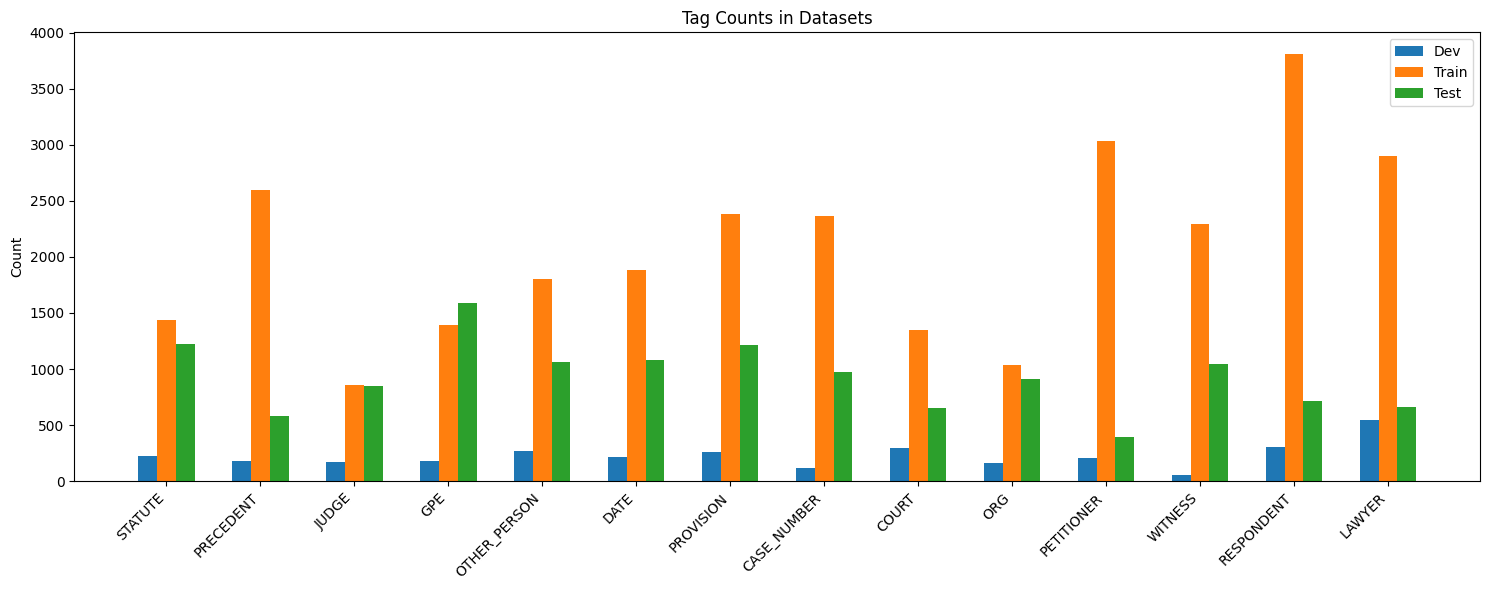

In [21]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

width = 0.2

x = np.arange(len(dev_ent_count.keys()))

ax.bar(x - width, dev_ent_count.values(), width, label='Dev')
ax.bar(x, train_ent_count.values(), width, label='Train')
ax.bar(x + width, test_ent_count.values(), width, label='Test')

ax.set_xticks(x)
ax.set_xticklabels(dev_ent_count.keys(), rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Tag Counts in Datasets')
ax.legend()

plt.tight_layout()
plt.show()

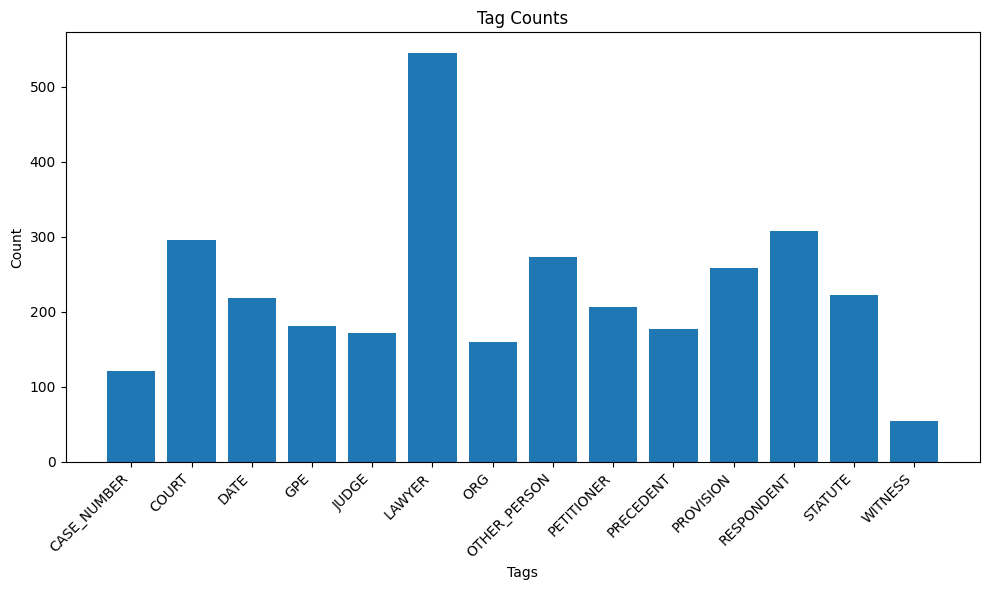

In [22]:
import matplotlib.pyplot as plt

def plot_tag_counts(ent_count):
    sorted_items = sorted(ent_count.items(), key=lambda item: item[0])
    tags, counts = zip(*sorted_items)
    plt.figure(figsize=(10, 6))
    plt.bar(tags, counts)
    plt.xlabel("Tags")
    plt.ylabel("Count")
    plt.title("Tag Counts")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

plot_tag_counts(dev_ent_count)




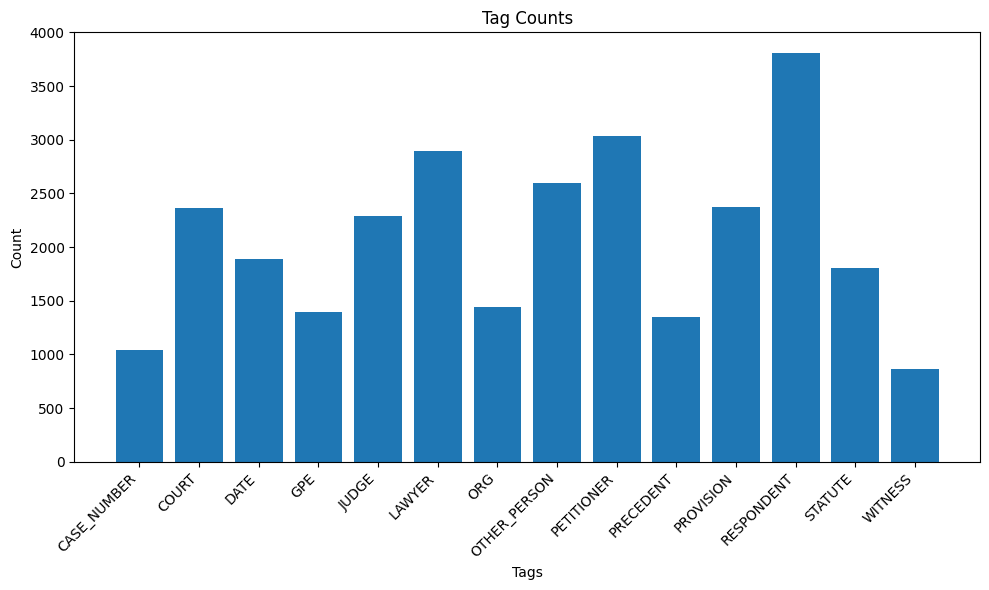

In [23]:
plot_tag_counts(train_ent_count)

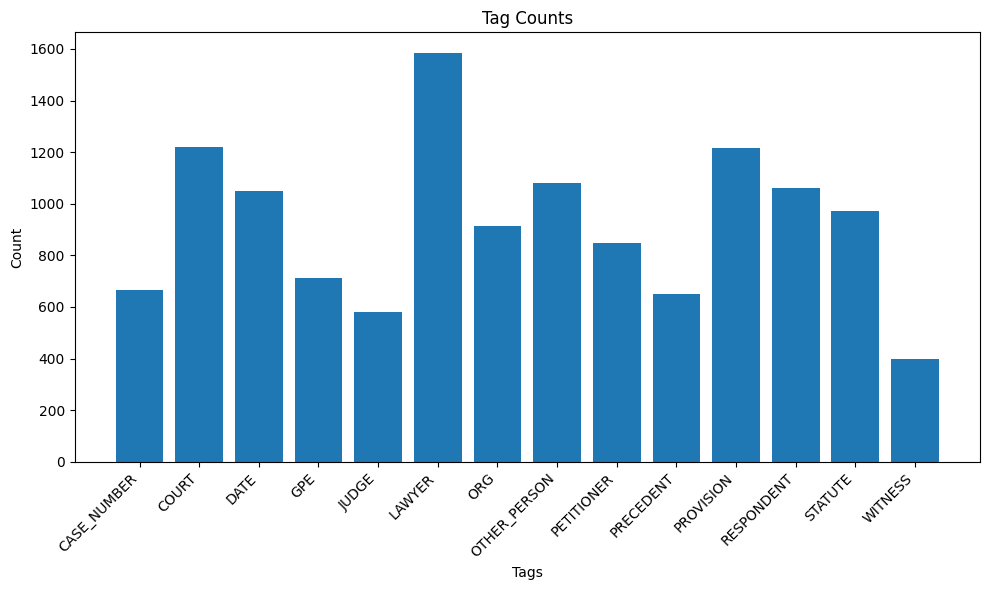

In [24]:
plot_tag_counts(test_ent_count)

In [25]:
def count_all_os(df):
  ctr = 0
  for _, row in df.iterrows():
      if all(tag == 'O' for tag in row['tags']):
          ctr += 1
  return ctr

In [26]:
print(f"Count of O-only entries in dev_df_formatted: {count_all_os(dev_df_formatted)}")
print(f"Count of O-only entries in train_df_formatted: {count_all_os(train_df_formatted)}")
print(f"Count of O-only entries in test_df_formatted: {count_all_os(test_df_formatted)}")

Count of O-only entries in dev_df_formatted: 184
Count of O-only entries in train_df_formatted: 2197
Count of O-only entries in test_df_formatted: 565


In [27]:
print(f"Number of rows in dev_df_cleaned: {len(dev_df_formatted)}")
print(f"Number of rows in train_df_cleaned: {len(train_df_formatted)}")
print(f"Number of rows in test_df_cleaned: {len(test_df_formatted)}")

Number of rows in dev_df_cleaned: 1074
Number of rows in train_df_cleaned: 10995
Number of rows in test_df_cleaned: 4501


In [28]:
def drop_rows_with_only_o_tags(df):
  new_df = df.copy()
  rows_to_drop = []
  for index, row in new_df.iterrows():
    if all(tag == 'O' for tag in row['tags']):
      rows_to_drop.append(index)
  new_df = new_df.drop(rows_to_drop)
  return new_df

In [29]:
dev_df_cleaned = drop_rows_with_only_o_tags(dev_df_formatted)
train_df_cleaned = drop_rows_with_only_o_tags(train_df_formatted)
test_df_cleaned = drop_rows_with_only_o_tags(test_df_formatted)

In [30]:
print(f"Count of O-only entries in dev_df_formatted: {count_all_os(dev_df_cleaned)}")
print(f"Count of O-only entries in train_df_formatted: {count_all_os(train_df_cleaned)}")
print(f"Count of O-only entries in test_df_formatted: {count_all_os(test_df_cleaned)}")

Count of O-only entries in dev_df_formatted: 0
Count of O-only entries in train_df_formatted: 0
Count of O-only entries in test_df_formatted: 0


In [31]:
print(f"Number of rows in dev_df_cleaned: {len(dev_df_cleaned)}")
print(f"Number of rows in train_df_cleaned: {len(train_df_cleaned)}")
print(f"Number of rows in test_df_cleaned: {len(test_df_cleaned)}")

Number of rows in dev_df_cleaned: 890
Number of rows in train_df_cleaned: 8798
Number of rows in test_df_cleaned: 3936


In [32]:
dev_df_cleaned.to_json("data_cleaned_original_split/dev.json", orient="records")
train_df_cleaned.to_json("data_cleaned_original_split/train.json", orient="records")
test_df_cleaned.to_json("data_cleaned_original_split/test.json", orient="records")

In [33]:
merged_df = pd.concat([dev_df_cleaned, train_df_cleaned, test_df_cleaned], ignore_index=True)

print("With duplicates:", len(merged_df))
merged_df['tokens_tuple'] = merged_df['tokens'].apply(tuple)
merged_df = merged_df.drop_duplicates(subset=['tokens_tuple'])
merged_df = merged_df.drop(['tokens_tuple'], axis=1)
print("Without duplicates:", len(merged_df))

With duplicates: 13624
Without duplicates: 13612


In [34]:
merged_ent_count = tabulate_unique(merged_df)

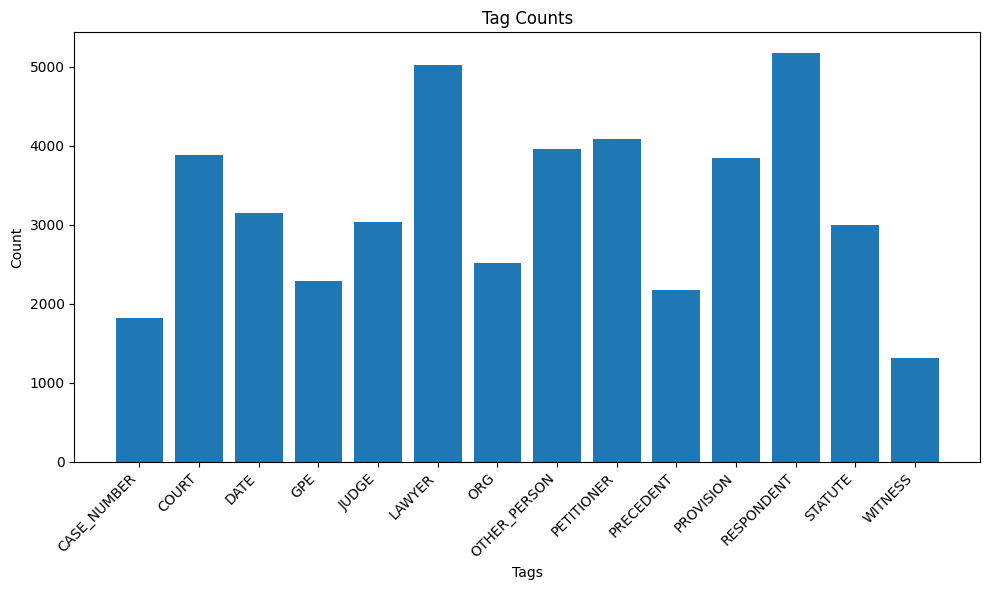

In [35]:
plot_tag_counts(merged_ent_count)

In [36]:
merged_df.to_json("data_cleaned_merged/dataset.json", orient="records")

In [37]:
def get_tags_and_probs(count1, count2):
    tags = set(count1.keys()).union(set(count2.keys()))

    len1 = sum(count1.values())
    probs1 = np.array([count1.get(tag, 0) / len1 for tag in tags])
    len2 = sum(count2.values())
    probs2 = np.array([count2.get(tag, 0) / len2 for tag in tags])

    return tags, probs1, probs2

In [38]:
from scipy.spatial.distance import jensenshannon

def compute_js_divergence(data1, data2):
    tags, probs1, probs2 = get_tags_and_probs(data1, data2)
    return jensenshannon(probs1, probs2)

In [39]:
compute_js_divergence(train_ent_count, test_ent_count)

0.10527845573522993

In [40]:
from sklearn.model_selection import train_test_split

def find_best_random_state(df, num_random_states=10):
    best_state = None
    best_divergence = float('inf')

    for random_state in range(num_random_states):
        split_train_df, split_test_df = train_test_split(df, test_size=0.2, random_state=random_state)

        split_train_ent_count = tabulate_unique(split_train_df)
        split_test_ent_count = tabulate_unique(split_test_df)

        js_divergence = compute_js_divergence(split_train_ent_count, split_test_ent_count)

        if js_divergence < best_divergence:
            best_divergence = js_divergence
            best_state = random_state

    return best_state, best_divergence

best_random_state, best_divergence = find_best_random_state(merged_df, num_random_states=1000)
print(f"Best random_state: {best_random_state} with JS Divergence: {best_divergence}")

Best random_state: 84 with JS Divergence: 0.007921059278485604


In [41]:
new_train_df, new_test_df = train_test_split(merged_df, test_size=0.2, random_state=best_random_state)

In [42]:
new_train_ent_count = tabulate_unique(new_train_df, True)

Tag             Count
------------  -------
COURT            3086
PRECEDENT        1735
CASE_NUMBER      1448
GPE              1841
ORG              1981
PETITIONER       3236
RESPONDENT       4118
JUDGE            2410
PROVISION        3048
WITNESS          1055
STATUTE          2369
DATE             2499
OTHER_PERSON     3156
LAWYER           3986


In [43]:
new_test_ent_count = tabulate_unique(new_test_df, True)

Tag             Count
------------  -------
OTHER_PERSON      796
PROVISION         799
STATUTE           624
JUDGE             629
COURT             792
PETITIONER        846
RESPONDENT       1057
LAWYER           1039
GPE               445
CASE_NUMBER       375
DATE              651
WITNESS           259
PRECEDENT         441
ORG               529


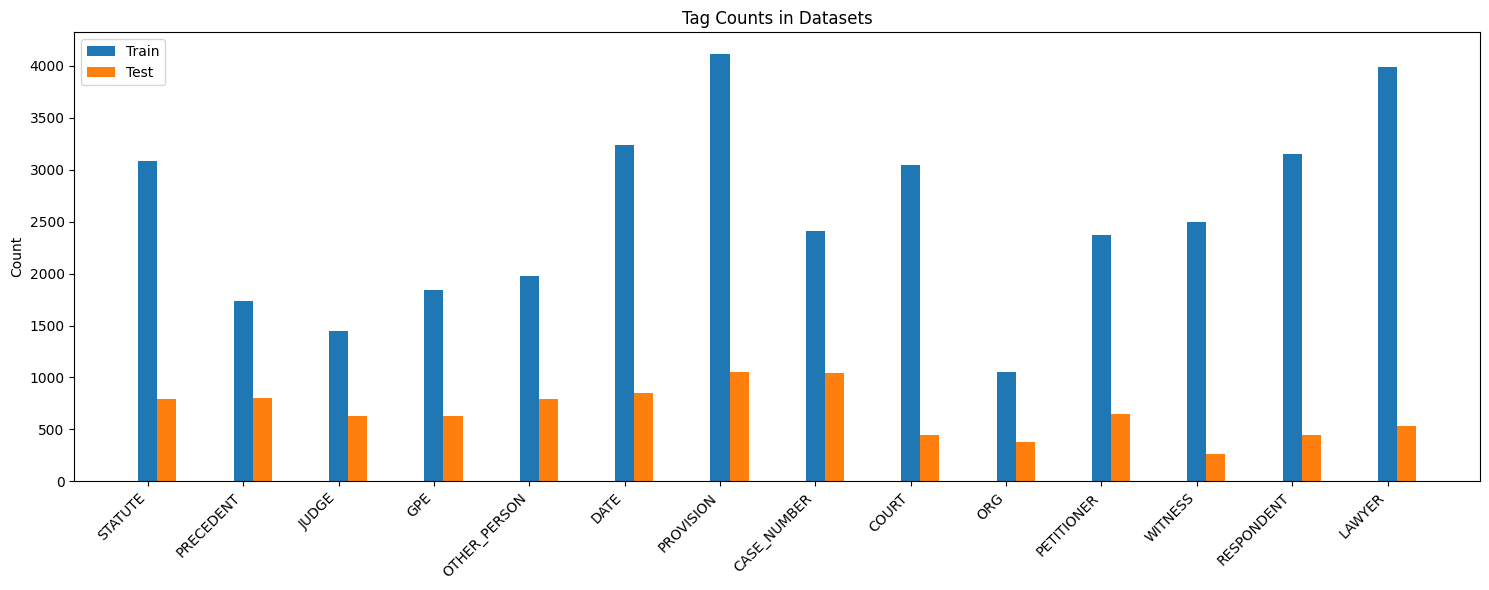

In [44]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 6))

width = 0.2

x = np.arange(len(new_train_ent_count.keys()))

ax.bar(x, new_train_ent_count.values(), width, label='Train')
ax.bar(x + width, new_test_ent_count.values(), width, label='Test')

ax.set_xticks(x)
ax.set_xticklabels(dev_ent_count.keys(), rotation=45, ha='right')
ax.set_ylabel('Count')
ax.set_title('Tag Counts in Datasets')
ax.legend()

plt.tight_layout()
plt.show()

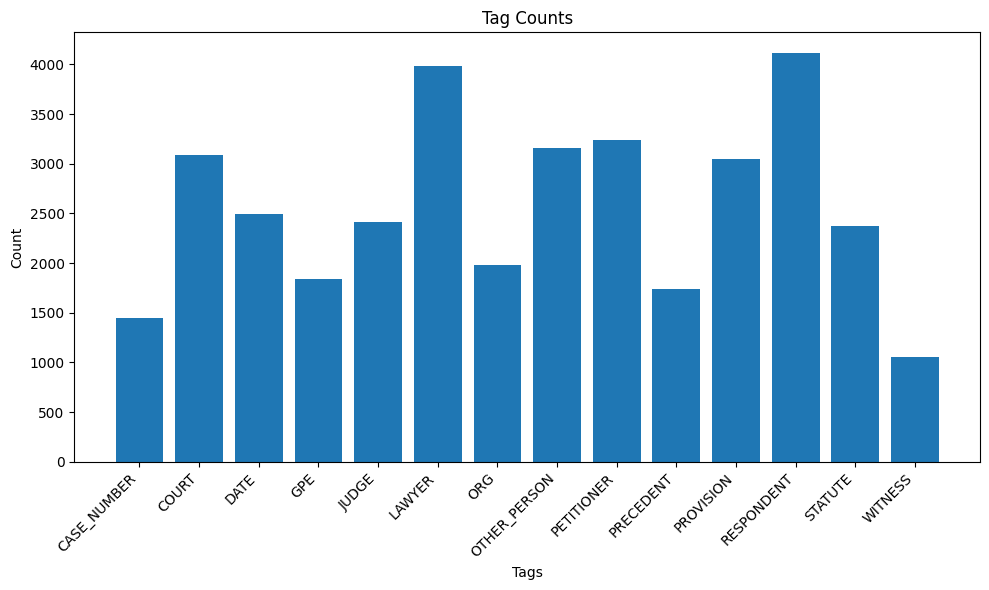

In [45]:
plot_tag_counts(new_train_ent_count)

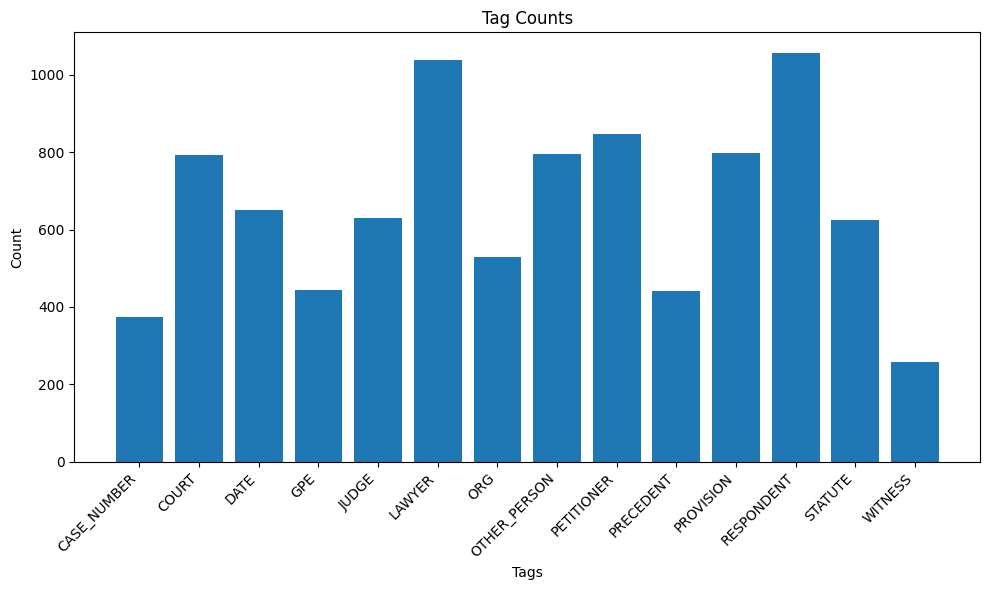

In [46]:
plot_tag_counts(new_test_ent_count)

In [47]:
new_train_df.to_json("data_cleaned_balanced_split/train.json", orient="records")
new_test_df.to_json("data_cleaned_balanced_split/test.json", orient="records")

In [ ]:
# prompt: zip all folders in /content/ and download

!zip -r /content/data.zip /content/
from google.colab import files
files.download("/content/data.zip")
